In [1]:
### imporitng lib

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))


In [ ]:
# data reading 

In [5]:
df = pd.read_csv("../data/final_data.csv")

In [2]:
#df.info()

In [6]:
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

In [7]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [8]:
# visualize the structure
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

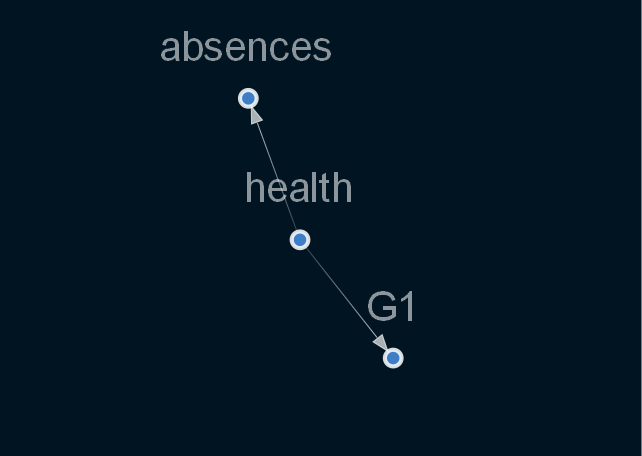

In [14]:

from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

## preparing the data for learning 

In [15]:
df = pd.read_csv("../data/final_data.csv")
df.head(5)

,Trip ID,Trip_Origin_lat,Trip_Origin_lng,Trip_Destn_lat,Trip_Destn_lng,Distance,Speed,driver_id,driver_action,Month,Day,Hour,Date,Holiday,Weekday,EDate
0,392001,6.60,3.28,6.45,3.39,20.98,217.00,243828,accepted,July,Thursday,9,2021-07-01,False,3,2021-07-01
1,392001,6.60,3.28,6.45,3.39,20.98,217.00,243588,rejected,July,Thursday,9,2021-07-01,False,3,2021-07-01
2,392001,6.60,3.28,6.45,3.39,20.98,217.00,243830,rejected,July,Thursday,9,2021-07-01,False,3,2021-07-01
3,392001,6.60,3.28,6.45,3.39,20.98,217.00,243539,rejected,July,Thursday,9,2021-07-01,False,3,2021-07-01
4,392001,6.60,3.28,6.45,3.39,20.98,217.00,171653,rejected,July,Thursday,9,2021-07-01,False,3,2021-07-01


In [16]:
import numpy as np

struct_data = df.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['driver_action', 'Month', 'Day', 'Date', 'Holiday', 'EDate']


In [17]:
# changing to numeric values 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,Trip ID,Trip_Origin_lat,Trip_Origin_lng,Trip_Destn_lat,Trip_Destn_lng,Distance,Speed,driver_id,driver_action,Month,Day,Hour,Date,Holiday,Weekday,EDate
0,392001,6.60,3.28,6.45,3.39,20.98,217.00,243828,0,3,4,9,0,0,3,0
1,392001,6.60,3.28,6.45,3.39,20.98,217.00,243588,1,3,4,9,0,0,3,0
2,392001,6.60,3.28,6.45,3.39,20.98,217.00,243830,1,3,4,9,0,0,3,0
3,392001,6.60,3.28,6.45,3.39,20.98,217.00,243539,1,3,4,9,0,0,3,0
4,392001,6.60,3.28,6.45,3.39,20.98,217.00,171653,1,3,4,9,0,0,3,0


In [ ]:
# applying notears algorithm
from causalnex.structure.notears import from_pandas

sm = from_pandas(struct_data)

**and visualise the learned StructureModel using the plot function.**

In [ ]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))